# Local activation analysis of EEG signals`

*Updated for medusa-kernel 1.4.0 (14 jul. 2025)*

This tutorial walks you through how to compute and visualize **local activation metrics** in EEG signals using the `medusa-kernel` library.

Local activation metrics analyze channels or sources **independently** to
provide localized insights into brain activity, being used in cognitive
neuroscience, clinical studies, and BCI research.

This tutorial covers the following local activation features:

- **Spectral metrics** — derived from the Power Spectral Density (PSD):
  - Band-specific power (absolute/relative)
  - Spectral entropy
  - Median frequency

- **Non-linear metrics** — based on the complexity or irregularity of the signal:
  - Sample entropy
  - Multiscale entropy
  - Lempel-Ziv complexity

You will learn how to:
- Preprocess raw EEG recordings
- Extract key spectral and non-linear features
- Visualize results using topographic maps and statistical summaries

📘 *For reference, see the [Medusa documentation](https://medusa.readthedocs.io).*


## Imports

Install dependencies and clone the repository to download the signals that
will be used in this notebook

<div class="alert alert-block alert-danger">
Important: execute the following cell **only** if you're using Google Collab!
</div>

In [ ]:
from idlelib.configdialog import changes
!pip install medusa-kernel
!git clone https://github.com/medusabci/medusa-tutorials.git

Import the modules that will be used in this notebook.

In [19]:
# General imports
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
from matplotlib import colors, cm
import numpy as np
import glob

# Medusa imports
from medusa import components
from medusa import transforms
from medusa.frequency_filtering import FIRFilter
from medusa.local_activation import spectral_parameteres, nonlinear_parameters
from medusa.transforms import power_spectral_density
from medusa.epoching import get_epochs
from medusa.plots.head_plots import TopographicPlot, ConnectivityPlot

print('\nPackages imported correctly!')


Packages imported correctly!


## Download the dataset

As strong supporters of open science, we have released and adapted some
valuable datasets that can be very useful for researchers and practitioners.
These datasets can be downloaded manually from www.medusabci.com/datasets/ or
using a simple API. In this case, we will use the API. Run the following cell
to download the GIB-UVa ERP dataset [1].

Each file is an instance of medusa.data_structures.Recording. This class
contains the information of the performed experiment and the recorded biosignals
In this case, the recordings contain an instance of
medusa.components.ERPSpellerData, which is the default class for this
experiment. Additionally, all recordings contain a medusa.meeg.EEG instance.

## Explore the EEG file

Once we have downloaded the EEG recording dataset, we will import the files and extract
interesting information such as the channels used, the sampling frequency, or a copy of the signal.

In [12]:
# Load one recording from the dataset
recording = components.Recording.load('rest_eeg/S01.rec.bson')

# Get the EEG signal and time-stamps vector from recording
signal = recording.eeg.signal.copy()
times = recording.eeg.times.copy()

# Get the EEG Channel set and sampling rate
ch_set = recording.eeg.channel_set
fs = recording.eeg.fs

# Print recording info
print('\n> Data exploration:')
print(f'\t- Sampling rate (Hz): {fs}')
print(f'\t- EEG channels: {ch_set.l_cha}')
print(f'\t- Signal duration (s): {len(times)/fs}')


> Data exploration:
	- Sampling rate (Hz): 250.0
	- EEG channels: ['FP1', 'FP2', 'F3', 'FZ', 'F4', 'T7', 'C3', 'CZ', 'C4', 'T8', 'P3', 'PZ', 'P4', 'F7', 'F8', 'POZ']
	- Signal duration (s): 311.104


## Preprocessing

This section performs basic EEG preprocessing, including:
- **Bandpass filtering** to retain neural frequencies of interest (1–70 Hz).
- **Notch filtering** to suppress power line noise (e.g. 50 Hz).
- **Epoching** to divide the continuous signal into fixed-length 5-second segments for further analysis.

For additional preprocessing techniques, consider:
- **`medusa.preprocessing.spatial_filtering`**
  Spatial filters such as:
  - **car** function to apply common average reference (CAR)
  - **LaplacianFilter** – Highly configurable laplacian filter

- **`medusa.preprocessing.artifact_removal`**
  Tools for automated or semi-automated artifact correction:
  - **ICA** – Independent Component Analysis for separating and removing artifacts
  - **ArtifactRegression** – Regression-based correction (e.g., EOG artifacts)
  - **reject_noisy_epochs** – Automatic rejection of high-amplitude or contaminated trials





In [11]:
# Get main EEG frequency bands: Delta (1-4 Hz), Theta (4-8 Hz), Alpha (8-13
# Hz), Beta (13-30 Hz) and Gamma (30-70 Hz)
bp_filt = FIRFilter(order=1000, cutoff=(1, 70), btype='bandpass')
signal_prep = bp_filt.fit_transform(signal, fs)

# Narrow bandstop filter from 49–51 Hz to suppress power line interference.
bs_filt = FIRFilter(order=1001, cutoff=(49, 51), btype='bandstop')
signal_prep = bs_filt.fit_transform(signal_prep, fs)

# Divide the signal into 5-second non-overlapping segments
signal_epochs = get_epochs(
    signal=signal_prep,
    epochs_length=int(5*fs),
    stride=None,
    norm=None
)

print('\n> Preprocessing applied correctly!')


Preprocessing applied correctly!


## Spectral Analysis

### Power Spectral Density (PSD) estimation
In this section, we estimate the **Power Spectral Density (PSD)** of the EEG signal using the **Welch method**, which provides a robust frequency-domain representation by averaging periodograms from overlapping windows[2].

Key steps:

- A **Hamming window** of 3 seconds is applied to each 5-second EEG epoch.
- **50% overlap** ensures smoother spectral estimates.
- PSD is computed for each epoch, frequency, and channel using Medusa’s `power_spectral_density` function.
- The result is averaged across all epochs to obtain a mean PSD per channel.

We then visualize the PSD for two study channels (**Fz** and **POz**) and overlay the **global average** across all channels for comparison.

This frequency analysis helps identify dominant rhythms (e.g., alpha) and compare spectral activity between regions (e.g., frontal vs. occipital).

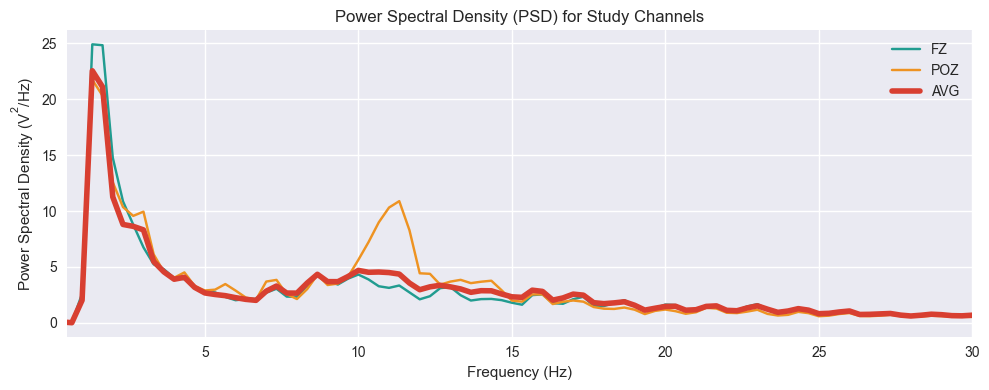

In [20]:
# --- Define Welch method parameters for PSD estimation ---
window_length = 3  # Length in seconds of each FFT window
segment_pct = (window_length / 5) * 100  # Segment size as % of epoch length (5 s)
overlap_pct = 50  # Percentage of overlap between windows
window = 'hamming'  # Window function to apply (see scipy.signal.welch)

# --- Compute the Power Spectral Density (PSD) for each channel and epoch ---
freq_array, psd = power_spectral_density(
    signal=signal_epochs,
    fs=fs,
    segment_pct=segment_pct,
    overlap_pct=overlap_pct,
    window=window
) # shape: (epochs, frequencies, channels)

# Average PSD
psd_avg = psd.mean(axis=0)  # shape: (frequencies, channels)

# --- Plot the PSD for selected study channels: Fz, C3, C4 ---
fig, ax = plt.subplots(figsize=(10, 4))

# Plot selected channels
channel_labels = ['FZ', 'POZ']
channel_indices = [0, 15]  # Adjust if your channel order differs
colors = ['#219C90', '#EE9322']

for idx, ch_idx in enumerate(channel_indices):
    ax.plot(freq_array, psd_avg[:, ch_idx],
            label=channel_labels[idx],
            color=colors[idx])

# Plot average PSD across channels
ax.plot(freq_array, psd_avg.mean(axis=1),
        label='AVG',
        color='#D83F31',
        linewidth=4)

# --- Customize plot appearance ---
ax.set_xlim(0.5, 30)  # Focus on the most relevant frequency range
ax.set_title('Power Spectral Density (PSD) for Study Channels')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel(r'Power Spectral Density $\mathregular{(V^2/Hz)}$')
ax.legend(loc='upper right')
ax.grid(True)
plt.tight_layout()
plt.show()

### Band Power Topography

In this subsection, we analyze the **relative power** of canonical EEG frequency bands across the scalp:

- **Delta** (1–4 Hz)
- **Theta** (4–8 Hz)
- **Alpha** (8–13 Hz)
- **Beta** (13–30 Hz)

We first normalize the Power Spectral Density (PSD) using `normalize_psd` to compute **relative band power**, which represents the proportion of power in a given band relative to the total spectral power — a more interpretable and comparable measure across subjects and sessions.

Using Medusa's `band_power` function, we extract the average relative power for each frequency band and each EEG channel.

To visualize the spatial distribution of neural activity, we plot **topographic maps** for each frequency band. These maps provide insight into:

- Regional dominance of spectral rhythms (e.g., posterior alpha, frontal theta)
- Power asymmetries or focal enhancements
- Overall scalp dynamics during resting or task-related EEG

Each plot uses interpolation for smooth representation, and colorbars are added to interpret power magnitude.


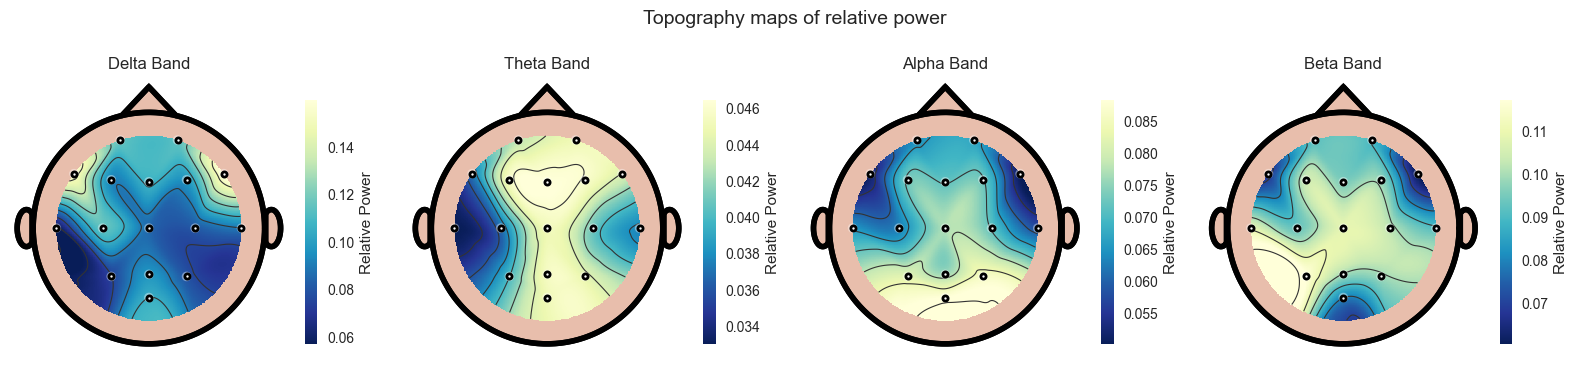

In [64]:
# Let us define the canonical frequency bands
freq_bands = [[1,4],[4,8],[8,13],[13,30]]
band_labels = ['Delta', 'Theta', 'Alpha', 'Beta']

# Normalize PSD to calculate relative band powers afterwards
psd_norm = transforms.normalize_psd(psd)

# Calculate the mean relative power for each band
powers = list()
for i, band in enumerate(freq_bands):
    band_pow_values = spectral_parameteres.band_power(
        psd=psd_norm, fs=fs,
        target_band=band)
    powers.append(band_pow_values.mean(axis=0))

# --- Plot topographic maps for each frequency band ---
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i, (ax, band_label) in enumerate(zip(axes, band_labels)):
    topo = TopographicPlot(
        axes=ax,
        channel_set=ch_set,
        interpolate=True,
        plot_channel_points=True
    )
    topo.update(values=powers[i])
    ax.set_title(f'{band_label} Band')

    # Add colorbar for each subplot
    cbar = fig.colorbar(topo.plot_handles['color-mesh'],
                        ax=ax, orientation='vertical',
                        shrink=0.8)
    cbar.set_label('Relative Power')

plt.suptitle('Topography maps of relative power', fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Median Alpha Frequency

In this section, we compute the **median frequency** within the **alpha band (8–13 Hz)** using `median_frequency`.
This metric captures the central point of spectral power distribution in the alpha range, offering a more robust and interpretable alternative to peak frequency — especially in noisy or non-stationary data.

We visualize the distribution of alpha median frequencies across EEG channels **Fz**, **Pz**, and **POz** using boxplots.
Each boxplot summarizes the variability across epochs, helping us identify differences in dominant alpha rhythms across brain regions.

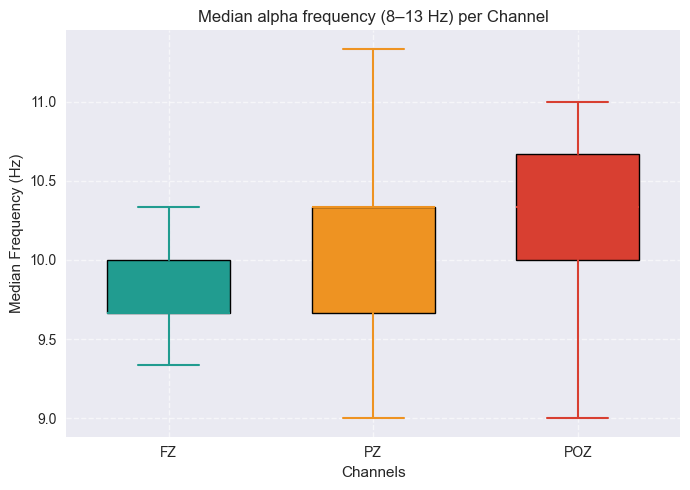

In [62]:
# --- Define the channels and colors for plotting ---
channels = ['FZ', 'PZ', 'POZ']  # Make sure casing matches ch_set.l_cha
colors = ['#219C90', '#EE9322', '#D83F31']  # One color per channel

# --- Compute median frequency in alpha band (8–13 Hz) ---
mf_alpha = spectral_parameteres.median_frequency(psd=psd, fs=fs, target_band=[8, 13])

# --- Show data in boxplots ---
fig, ax = plt.subplots(figsize=(7, 5))
positions = np.arange(len(channels))

for i, ch in enumerate(channels):
    ch_idx = ch_set.l_cha.index(ch)
    box = ax.boxplot(
        mf_alpha[:, ch_idx],
        positions=[positions[i]],
        widths=0.6,
        patch_artist=True,
        showfliers=False
    )
    # Apply custom color to the box
    for patch in box['boxes']:
        patch.set_facecolor(colors[i])
    # Match whiskers and medians with the box color for consistency
    for element in ['whiskers', 'caps', 'medians']:
        for item in box[element]:
            item.set_color(colors[i])
            item.set_linewidth(1.5)

ax.set_xticks(positions)
ax.set_xticklabels(channels)
ax.set_xlabel('Channels')
ax.set_ylabel('Median Frequency (Hz)')
ax.set_title('Median alpha frequency (8–13 Hz) per Channel')
ax.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Non-linear Analysis

In contrast to spectral analysis measures, nonlinear analysis measures seek to describe
the complex structure of the systems, which can be characterized by the nonlinear relationships
of the associated signals. In this sense, this type of analysis seeks to describe signal
characteristics such as its irregularity, complexity, or long-range dependencies.

Medusa-Kernel provides some of the most typically employed nonlinear irregularity and complexity
analysis methods. In this section we will explore the use of sample entropy (SampEn) [4], which will
give us an idea of the irregularity of the signal. Next, we will employ multiscale entropy (MSE) [4],
which calculates signal irregularity using SampEn at different time scales, thus providing insight into
signal complexity. Finally, Lempel-Ziv complexity (LZC) [5], which evaluates the randomness of finite
sequences based on the number of distinct patterns in a signal, will be used.

### Sample Entropy

Non-linear analysis measurements study temporal relationships between signal samples, so to better capture
these properties, it is necessary to use longer time windows than in spectral analysis. For this reason, we
will perform a new windowing prior to the calculation of the metrics.

It is important to note that in order to optimize the calculation of these multi-channel measurements, MEDUSA
implements these analyses using concurrent programming. For this reason, the use of too long signals can lead
to memory allocation errors.

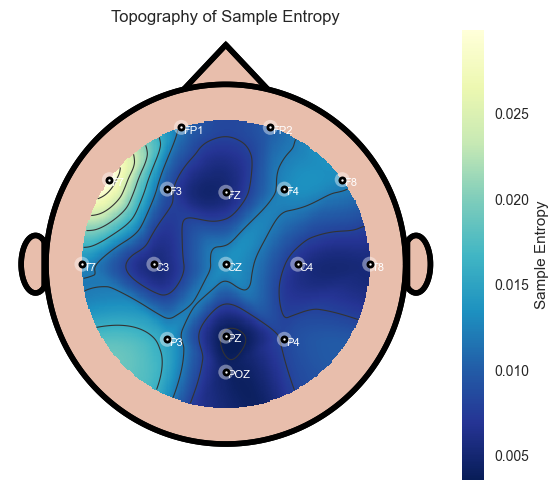

In [67]:
# --- Define longer epochs for nonlinear feature extraction (20s) ---
signal_long_epochs = get_epochs(
    signal=signal,
    epochs_length=int(20 * fs),
    stride=None,
    norm=None
)

# --- SampEn parameters ---
m = 1           # Sequence length
r = 0.3         # Tolerance
dist_type = 'chebyshev'  # Distance metric

# --- Compute Sample Entropy across channels and epochs ---
signal_sampen = nonlinear_parameters.sample_entropy(
    signal=signal_long_epochs,
    m=m, r=r,
    dist_type=dist_type
)

# --- Plot average SampEn topography ---
fig, ax = plt.subplots(figsize=(6, 5))

# Initialize topographic plot
topo = TopographicPlot(
    axes=ax,
    channel_set=ch_set,
    interpolate=True,
    plot_channel_points=True,
    plot_channel_labels=True,
)

# Update plot with mean SampEn values across epochs
topo.update(values=signal_sampen.mean(axis=0))

# Add colorbar
cbar = fig.colorbar(topo.plot_handles['color-mesh'],
                    ax=ax, orientation='vertical',
                    fraction=0.046, pad=0.04)
cbar.set_label('Sample Entropy')

# Set title
ax.set_title('Topography of Sample Entropy')
plt.tight_layout()
plt.show()


### Multiscale Entropy

Next we will use the MSE calculation function, which performs the SampEn calculation on different versions of
the signal, to which a coarse-grained approximation will be applied.  To understand this process, see [5] and
the implementation in our documentation.

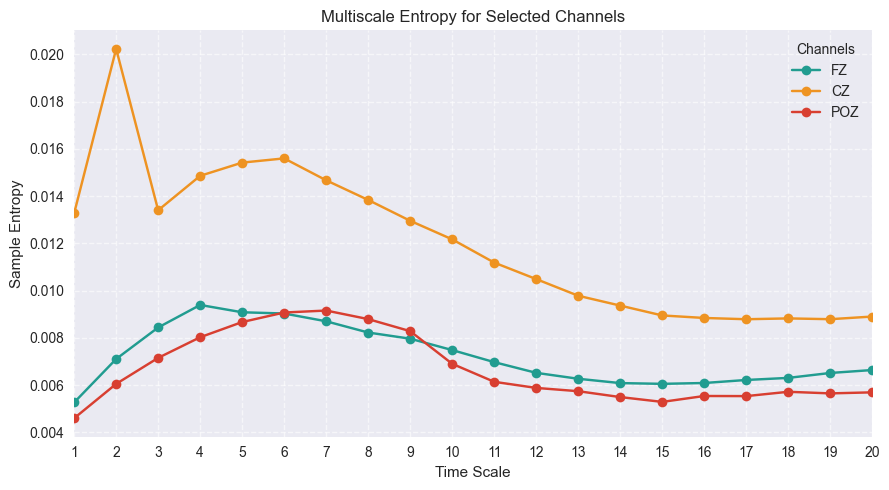

In [81]:
# --- Define MSE parameters ---
max_scale = 20       # Maximum scale factor for coarse-graining
m = 1                # Embedding dimension (sequence length)
r = 0.3              # Tolerance threshold

# --- Define channels of interest ---
channels = ['FZ', 'CZ', 'POZ']
colors = ['#219C90', '#EE9322', '#D83F31']  # One color per channel
cha_idx = [ch_set.l_cha.index(c) for c in channels]

# --- Extract EEG data for selected channels ---
# Shape: (epochs, samples, selected_channels)
signal_selected = signal_long_epochs[:, :, cha_idx]

# --- Compute MSE: output shape (epochs, scales, channels) ---
mse = nonlinear_parameters.multiscale_entropy(
    signal=signal_selected,
    max_scale=max_scale,
    m=m,
    r=r
)

# --- Average across epochs ---
mse_mean = mse.mean(axis=0)  # shape: (scales, channels)

# --- Plot MSE for selected channels ---
fig, ax = plt.subplots(figsize=(9, 5))
scales = np.arange(1, max_scale + 1)

for i, ch in enumerate(channels):
    ax.plot(scales, mse_mean[:, i], '-o', label=ch, color=colors[i])

# --- Customize plot ---
ax.set_xlim([1, max_scale])
ax.set_xticks(scales)
ax.set_xlabel('Time Scale')
ax.set_ylabel('Sample Entropy')
ax.set_title('Multiscale Entropy for Selected Channels')
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(title='Channels')

plt.tight_layout()
plt.show()



### Lempel-Ziv Complexity
LZC is a nonlinear analysis technique that evaluates the randomness of finite sequences based on the
number of distinct patterns in a signal and symbolic coding and is related to the Kolmogorov complexity.
Medusa-Kernel not only provides an optimal LZC implementation, but also a multiscale version to analyze
this measurement at different time scales of the signal. More information can be found in our documentation
multiscale_lempelziv_complexity function and in its original paper [6].

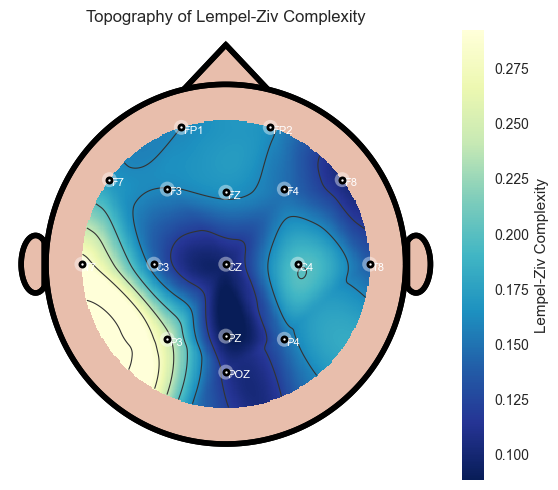

In [83]:
# --- Compute Lempel-Ziv Complexity (LZC) for each channel ---
lzc_results = nonlinear_parameters.lempelziv_complexity(signal=signal_long_epochs)  # shape: (epochs, channels)

# --- Compute mean LZC across epochs ---
lzc_mean = lzc_results.mean(axis=0)

# --- Plot LZC topography using TopographicPlot ---
fig, ax = plt.subplots(figsize=(6, 5))

# Initialize topographic plot
topo = TopographicPlot(
    axes=ax,
    channel_set=ch_set,
    interpolate=True,
    plot_channel_points=True,
    plot_channel_labels=True
)

# Update topographic image with mean LZC values
topo.update(values=lzc_mean)

# Add colorbar
cbar = fig.colorbar(topo.plot_handles['color-mesh'],
                    ax=ax, orientation='vertical',
                    fraction=0.046, pad=0.04)
cbar.set_label('Lempel-Ziv Complexity')

# Final formatting
ax.set_title('Topography of Lempel-Ziv Complexity')
plt.tight_layout()
plt.show()


## Summary and next steps

In this tutorial, we successfully explored how to analyze EEG signals using **local activation metrics** with `medusa-kernel`. We:

- Loaded and preprocessed EEG data
- Extracted **spectral** features (e.g., band power, spectral entropy)
- Computed **non-linear** features (e.g., sample entropy, MSE, LZC)
- Visualized channel-wise differences using **topographic maps** and **boxplots**

These techniques help us uncover localized patterns of brain activity across time, frequency, and complexity domains.

#### 🚀 Next Steps

Here are some ways to build on this analysis:

- **Condition Comparison**: Apply the same metrics to different cognitive or clinical conditions and compute contrasts.
- **Feature Aggregation**: Combine multiple features per channel for machine learning applications.
- **Source-Level Analysis**: Use source reconstruction to perform activation analysis in the cortical space.
- **Real-time Extension**: Integrate these metrics into real-time pipelines for neurofeedback or BCI applications.


## References

1. Welch, P. D. (1967).
   *The use of Fast Fourier Transform for the estimation of power spectra: A method based on time averaging over short, modified periodograms.*
   IEEE Transactions on Audio and Electroacoustics, 15(2), 70–73.
   [https://doi.org/10.1109/TAU.1967.1161901](https://doi.org/10.1109/TAU.1967.1161901)

2. Klimesch, W. (1999).  *EEG alpha and theta oscillations reflect cognitive and memory performance.*
   Brain Research Reviews, 29(2–3), 169–195.
   [https://doi.org/10.1016/S0165-0173(98)00056-3](https://doi.org/10.1016/S0165-0173(98)00056-3)

3. Marcos-Martínez, D., Martínez-Cagigal, V., Santamaría-Vázquez, E., Pérez-Velasco, S., & Hornero, R. (2021).
   *Neurofeedback training based on motor imagery strategies increases EEG complexity in elderly population.*
   Entropy, 23(12), 1–19.
   [https://doi.org/10.3390/e23121574](https://doi.org/10.3390/e23121574)

4. Escudero, J., Abásolo, D., Hornero, R., Espino, P., & López, M. (2006).
   *Analysis of electroencephalograms in Alzheimer’s disease patients with multiscale entropy.*
   Physiological Measurement, 27(11).
   [https://doi.org/10.1088/0967-3334/27/11/004](https://doi.org/10.1088/0967-3334/27/11/004)

5. Ibáñez-Molina, A. J., Iglesias-Parro, S., Soriano, M. F., & Aznarte, J. I.
   (2015). *Multiscale Lempel-Ziv complexity for EEG measures.*
   Clinical Neurophysiology, 126(3), 541–548.
   [https://doi.org/10.1016/j.clinph.2014.07.012](https://doi.org/10.1016/j.clinph.2014.07.012)